In [1]:
!pip install tensorflow_hub
!pip install bitarray
!pip -q install pybloom_live
!pip -q install pympler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 3.7 MB/s eta 0:00:00


#Import


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report,accuracy_score
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from copy import deepcopy
from keras.utils import to_categorical
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import murmurhash3_32
from bitarray import bitarray
import math
import random
from sklearn.metrics import confusion_matrix

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
if not os.path.exists('data'):
    # If data does not exist, execute the commands
    os.system('gdown 1ZkY2fggUconL46l9eKKDIsndufrcPyGs')
    os.system('unzip archive.zip -d data/')
else:
    print('data directory already exists. No action taken.')

In [4]:
df = pd.read_csv('data/malicious_phish.csv')

In [5]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [6]:
count = df.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

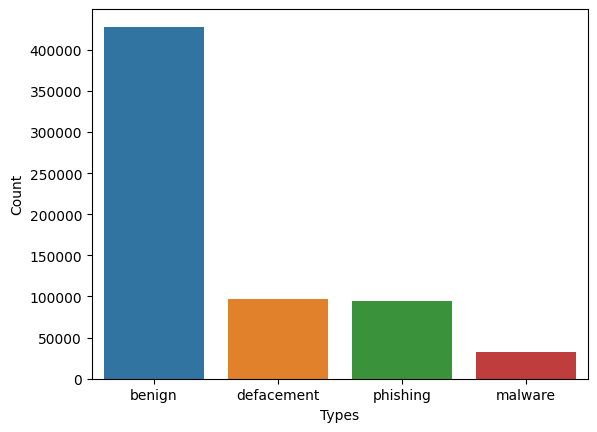

In [7]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [8]:
df['bad'] = df['type'].apply(lambda x: 0 if x == 'benign' else 1)
df.head()

,url,type,bad
0,br-icloud.com.br,phishing,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [9]:
count = df.bad.value_counts()
count

0    428103
1    223088
Name: bad, dtype: int64

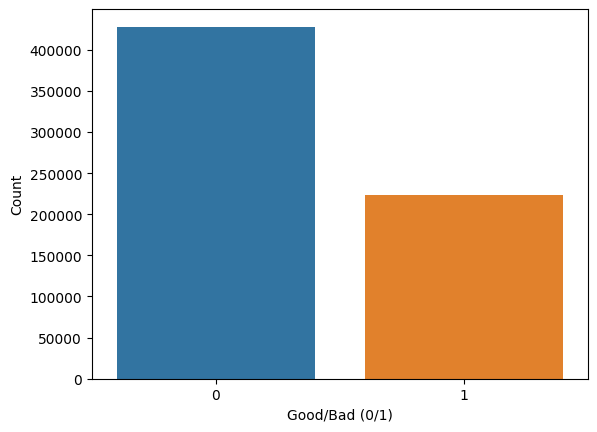

In [10]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Good/Bad (0/1)')
plt.ylabel('Count');

# Split data set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['url'], df['bad'], test_size=0.2, random_state=42
)

# Build and train model



In [12]:
# Tokenizer initialization and configuration
input_size = 1014
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(alphabet)

# Update word_index with one-hot encoding indices
tk.word_index = {char: i + 1 for i, char in enumerate(alphabet)}
tk.word_index[tk.oov_token] = len(tk.word_index) + 1

# Convert texts to sequences and pad them
train_sequences = tk.texts_to_sequences([s.lower() for s in X_train])
train_data = pad_sequences(train_sequences, maxlen=input_size, padding='post')
train_data = np.array(train_data, dtype='float32')

# Convert labels to numpy array
y_train = np.array(y_train)

# Create one-hot encoded embedding weights
vocab_size = len(tk.word_index)
embedding_weights = np.zeros((vocab_size + 1, 69))
for char, i in tk.word_index.items():
    embedding_weights[i, :] = np.eye(vocab_size, dtype='float32')[i-1]

# Model building
embedding_layer = Embedding(input_dim=vocab_size + 1, output_dim=69, input_length=input_size, weights=[embedding_weights])
inputs = Input(shape=(input_size,), name='input', dtype='int64')
x = embedding_layer(inputs)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(4, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Compile and train the model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(train_data, y_train, batch_size=256, epochs=10, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1014)]            0         
                                                                 
 embedding (Embedding)       (None, 1014, 69)          4830      
                                                                 
 conv1d (Conv1D)             (None, 1011, 64)          17728     
                                                                 
 max_pooling1d (MaxPooling1  (None, 505, 64)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 32320)             0         
                                                                 
 dense (Dense)               (None, 64)                2068544   
                                                             

4070/4070 [==============================] - 7s 2ms/step
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     85778
   Malicious       0.98      0.97      0.98     44461

    accuracy                           0.98    130239
   macro avg       0.98      0.98      0.98    130239
weighted avg       0.98      0.98      0.98    130239



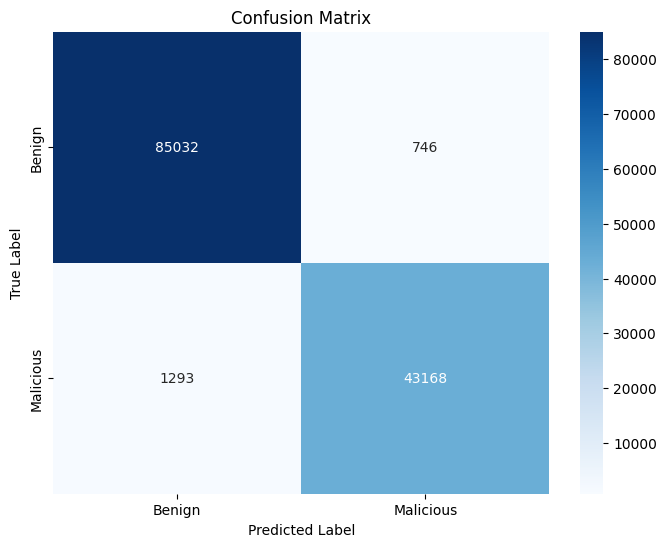

In [60]:
def evaluate_model():
  test_sequences = tk.texts_to_sequences([s.lower() for s in X_test])
  test_data = pad_sequences(test_sequences, maxlen=1014, padding='post')
  test_data = np.array(test_data, dtype='float32')
  y_pred = model.predict(test_data)

  # Convert probabilities to binary predictions
  y_pred_binary = (y_pred > 0.5).astype(int)

  # Now we calculate the confusion matrix
  cm = confusion_matrix(y_test, y_pred_binary)

  # To get precision, recall, and F1-score, you can use sklearn's classification report
  from sklearn.metrics import classification_report
  print(classification_report(y_test, y_pred_binary, target_names=['Benign', 'Malicious']))
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()


evaluate_model()

# Test model

In [14]:
def test_model(test_texts):
  test_texts = [s.lower() for s in test_texts]
  test_texts = tk.texts_to_sequences(test_texts)
  test_data = pad_sequences(test_texts, maxlen=1014, padding='post')
  test_data = np.array(test_data, dtype='float32')
  y =  model.predict(test_data)
  res =[]
  for f in y:
      res.append(f[0])
  return res

# Testing bloom filter functions





In [33]:
def test_learned_bloom_filter(bloom, test_urls, tau, predictions):
    labels = test_urls['bad'].to_numpy()
    urls = test_urls['url'].to_numpy()
    false_positives = 0
    false_negatives = 0
    query_times = []
    for i in range(len(predictions)):
        start_time = time.time()
        bloom_filter_contains_url = bloom.__contains__(urls[i])
        query_time = time.time() - start_time
        query_times.append(query_time)
        if predictions[i] < tau and labels[i] == 1:
            false_negatives += 1

        if predictions[i] >= tau:
            if labels[i] == 0 and bloom_filter_contains_url:
                false_positives += 1

        if predictions[i] < tau:
            url_added = urls[i] in added_to_bloom_filters
            if not bloom_filter_contains_url and url_added:
                false_negatives += 1

    # Calculate the false positive rate
    fpr = false_positives / len(urls)
    fnr = false_negatives / len(urls)
    # Calculate the average query time
    avg_query_time = sum(query_times) / len(query_times)

    return fpr, fnr, avg_query_time


In [34]:
def test_post_learned_bloom_filter(bloom, test_urls, tau, predictions):
    labels = test_urls['bad'].to_numpy()
    urls = test_urls['url'].to_numpy()
    false_positives = 0
    false_negatives = 0
    query_times = []
    for i in range(len(predictions)):
      start_time = time.time()
      bloom_filter_contains_url = bloom.__contains__(urls[i])
      query_time = time.time() - start_time
      query_times.append(query_time)
      url_added = urls[i] in added_to_bloom_filters
      if bloom_filter_contains_url and predictions[i] < tau and labels[i] == 0:
            false_positives += 1

      if predictions[i] < tau and labels[i] == 1:
          false_negatives += 1

    # Calculate the false positive rate
    fpr = false_positives / len(test_urls)
    fnr = false_negatives / len(test_urls)
    # Calculate the average query time
    avg_query_time = sum(query_times) / len(query_times)

    return fpr, fnr, avg_query_time

In [35]:
def test_normal_bloom_filter(bloom, test_urls):
  false_positives = 0
  false_negatives = 0
  query_times = []
  urls = test_urls['url'].to_numpy()
  labels = test_urls['bad'].to_numpy()
  for i in range(len(urls)):
      start_time = time.time()
      bloom_filter_contains_url = bloom.__contains__(urls[i])
      if bloom_filter_contains_url and urls[i] not in added_to_bloom_filters:
        false_positives += 1
      if not bloom_filter_contains_url and labels[i] == 1:
        false_negatives += 1
      query_time = time.time() - start_time
      query_times.append(query_time)


  # Calculate the false positive rate
  fpr = false_positives / len(urls)
  fnr = false_negatives / len(urls)
  # Calculate the average query time
  avg_query_time = sum(query_times) / len(query_times)
  return fpr, fnr, query_time

# Compare different learned bloom filter variances (Variant 1 & 2) vs normal bloom filter

In [43]:
import time
from pympler import asizeof
from pybloom_live import BloomFilter

random.seed(42)

tau = 0.9

malicious_urls_to_add =  df[df['bad'] == 1].sample(frac=0.5)

added_to_bloom_filters = set(malicious_urls_to_add['url'])
test_urls = df.sample(frac=0.1)

normal_bloom = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=u)
learned_bloom = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=0.001)
post_learned_bloom = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=0.001)

for data in malicious_urls_to_add['url']:
  normal_bloom.add(data)
  learned_bloom.add(data)
  post_learned_bloom.add(data)

fpr_normal_bloom, fnr_normal_bloom, time_normal_bloom = test_normal_bloom_filter(normal_bloom, test_urls)
predictions = test_model(test_urls['url'].to_numpy())

fpr_learned_bloom, fnr_learned_bloom, time_learned_bloom = test_learned_bloom_filter(learned_bloom, test_urls, tau, predictions)
fpr_post_learned_bloom, fnr_post_learned_bloom, time_post_learned_bloom = test_post_learned_bloom_filter(post_learned_bloom, test_urls, tau, predictions)

ml_model_size = asizeof.asizeof(model)
normal_bloom_size = asizeof.asizeof(normal_bloom)
learned_bloom_size = asizeof.asizeof(learned_bloom)
post_learned_bloom_size = asizeof.asizeof(post_learned_bloom)

2035/2035 [==============================] - 4s 2ms/step


In [61]:
fp_df = pd.DataFrame({
    "FP Rate (Normal BF)": [fpr_normal_bloom],
    "FP Rate (ML + BF)": [fpr_learned_bloom],
    "FP Rate (BF + ML)": [fpr_post_learned_bloom],
}, index=[""])

fn_df = pd.DataFrame({
    "Missed Rate (Normal BF)": [fnr_normal_bloom],
    "Missed Rate (ML + BF)": [fnr_learned_bloom],
    "Missed Rate (BF + ML)": [fnr_post_learned_bloom],
}, index=[""])

overall_metrics_df = pd.DataFrame({
    "Normal BF": [time_normal_bloom, normal_bloom_size / 1024],
    "ML + BF": [time_learned_bloom, (learned_bloom_size + ml_model_size) / 1024],
    "BF + ML": [time_post_learned_bloom, (normal_bloom_size + ml_model_size) / 1024],
}, index=["Average Query Time (seconds)", "Memory Footprint (kB)"])

print("Comparison of False Positive rates")
print(fp_df)


print("\nComparison of Missed Rates")
print(fn_df)

print("\nOverall Performance Metrics:")
print(overall_metrics_df)

Comparison of False Positive rates
  FP Rate (Normal BF)  FP Rate (ML + BF)  FP Rate (BF + ML)
             0.000353                0.0           0.000307

Comparison of Missed Rates
  Missed Rate (Normal BF)  Missed Rate (ML + BF)  Missed Rate (BF + ML)
                 0.162671               0.012347               0.012347

Overall Performance Metrics:
                               Normal BF     ML + BF     BF + ML
Average Query Time (seconds)    0.000003    0.000004    0.000004
Memory Footprint (kB)         216.406250  611.148438  611.148438


In [55]:
error_rates = [0.0001*i for i in range(1, 6)]
fpr_normal_bloom_results = []
fpr_learned_bloom_results = []
fpr_post_learned_bloom_results = []

fnr_learned_bloom_results = []
fnr_post_learned_bloom_results = []

time_normal_bloom_results = []
time_learned_bloom_results = []
time_post_learned_bloom_results = []

memory_normal_bloom_results = []
memory_learned_bloom_results = []
memory_post_learned_bloom_results = []

for er in tqdm(range(len(error_rates))):

  normal_bloom = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=error_rates[er])
  learned_bloom = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=error_rates[er])
  post_learned_bloom = BloomFilter(capacity=len(malicious_urls_to_add), error_rate=error_rates[er])

  for data in malicious_urls_to_add['url']:
    normal_bloom.add(data)
    learned_bloom.add(data)
    post_learned_bloom.add(data)

  fpr_normal_bloom, fnr_normal_bloom, time_normal_bloom = test_normal_bloom_filter(normal_bloom, test_urls)
  predictions = test_model(test_urls['url'].to_numpy())

  fpr_learned_bloom, fnr_learned_bloom, time_learned_bloom = test_learned_bloom_filter(learned_bloom, test_urls, tau, predictions)
  fpr_post_learned_bloom, fnr_post_learned_bloom, time_post_learned_bloom = test_post_learned_bloom_filter(post_learned_bloom, test_urls, tau, predictions)

  ml_model_size = asizeof.asizeof(model)
  normal_bloom_size = asizeof.asizeof(normal_bloom)
  learned_bloom_size = asizeof.asizeof(learned_bloom)
  post_learned_bloom_size = asizeof.asizeof(post_learned_bloom)

  memory_normal_bloom_results.append(normal_bloom_size / 1024)
  memory_learned_bloom_results.append((learned_bloom_size + ml_model_size) / 1024)
  memory_post_learned_bloom_results.append((post_learned_bloom_size + ml_model_size) / 1024)

  # Store results
  fpr_normal_bloom_results.append(fpr_normal_bloom)
  fpr_learned_bloom_results.append(fpr_learned_bloom)
  fpr_post_learned_bloom_results.append(fpr_post_learned_bloom)

  fnr_learned_bloom_results.append(fnr_learned_bloom)
  fnr_post_learned_bloom_results.append(fnr_post_learned_bloom)

  time_normal_bloom_results.append(time_normal_bloom)
  time_learned_bloom_results.append(time_learned_bloom)
  time_post_learned_bloom_results.append(time_post_learned_bloom)

  0%|          | 0/5 [00:00<?, ?it/s]

2035/2035 [==============================] - 4s 2ms/step


# Plotting


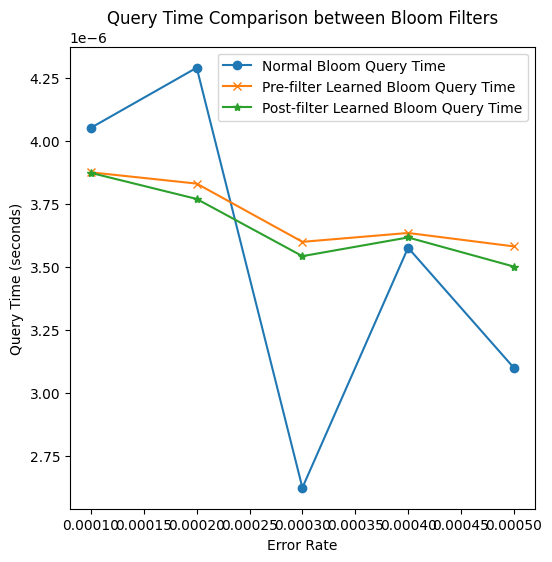

In [56]:
import matplotlib.pyplot as plt

# Plotting the query times
plt.figure(figsize=(6, 6))
plt.plot(error_rates, time_normal_bloom_results, label='Normal Bloom Query Time', marker='o')
plt.plot(error_rates, time_learned_bloom_results, label='Pre-filter Learned Bloom Query Time', marker='x')
plt.plot(error_rates, time_post_learned_bloom_results, label='Post-filter Learned Bloom Query Time', marker='*')

plt.xlabel('Error Rate')
plt.ylabel('Query Time (seconds)')
plt.title('Query Time Comparison between Bloom Filters')
plt.legend()
plt.show()

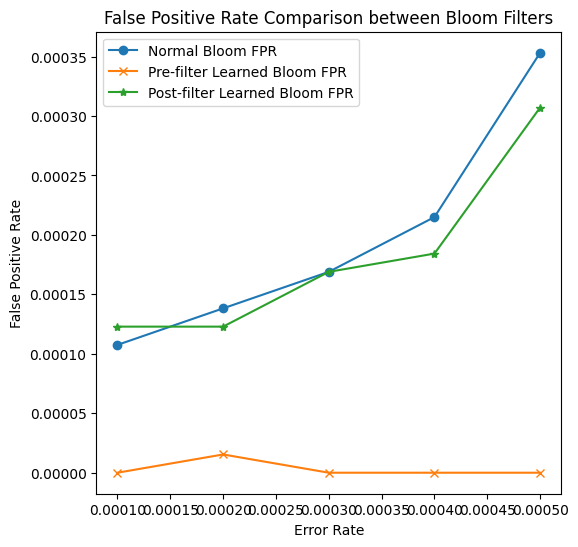

In [57]:
# Plotting the false positive rates
plt.figure(figsize=(6, 6))
plt.plot(error_rates, fpr_normal_bloom_results, label='Normal Bloom FPR', marker='o')
plt.plot(error_rates, fpr_learned_bloom_results, label='Pre-filter Learned Bloom FPR', marker='x')
plt.plot(error_rates, fpr_post_learned_bloom_results, label='Post-filter Learned Bloom FPR', marker='*')

plt.xlabel('Error Rate')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate Comparison between Bloom Filters')
plt.legend()
plt.show()

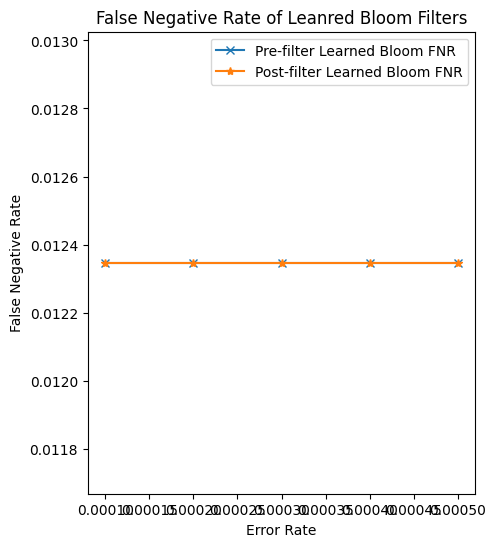

In [58]:
# Plotting the false negative rates
plt.figure(figsize=(5, 6))
plt.plot(error_rates, fnr_learned_bloom_results, label='Pre-filter Learned Bloom FNR', marker='x')
plt.plot(error_rates, fnr_post_learned_bloom_results, label='Post-filter Learned Bloom FNR', marker='*')
plt.xlabel('Error Rate')
plt.ylabel('False Negative Rate')
plt.title('False Negative Rate of Leanred Bloom Filters')
plt.legend()
plt.show()

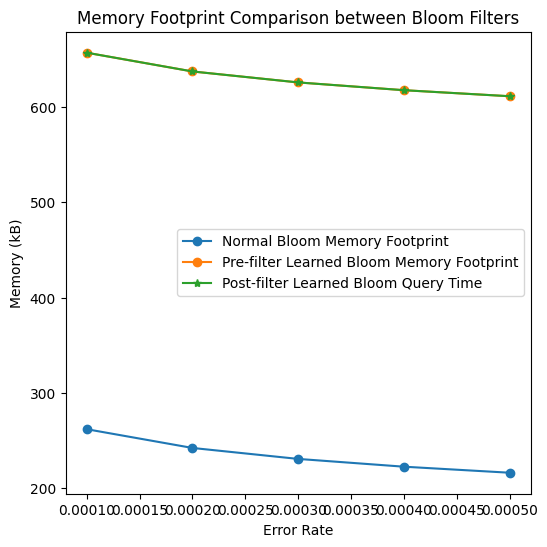

In [59]:
# Plotting the memory footprint
plt.figure(figsize=(6, 6))
plt.plot(error_rates, memory_normal_bloom_results, label='Normal Bloom Memory Footprint', marker='o')
plt.plot(error_rates, memory_learned_bloom_results, label='Pre-filter Learned Bloom Memory Footprint', marker='o')
plt.plot(error_rates, memory_post_learned_bloom_results, label='Post-filter Learned Bloom Query Time', marker='*')

plt.xlabel('Error Rate')
plt.ylabel('Memory (kB)')
plt.title('Memory Footprint Comparison between Bloom Filters')
plt.legend()
plt.show()